In [1]:
################################################
# Decision Tree Classification: CART
################################################

# 1. Exploratory Data Analysis
# 2. Data Preprocessing & Feature Engineering
# 3. Modeling using CART
# 4. Hyperparameter Optimization with GridSearchCV
# 5. Final Model
# 6. Feature Importance
# 7. Analyzing Model Complexity with Learning Curves (BONUS)
# 8. Visualizing the Decision Tree
# 9. Extracting Decision Rules
# 10. Extracting Python/SQL/Excel Codes of Decision Rules
# 11. Prediction using Python Codes
# 12. Saving and Loading Model

In [2]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
import graphviz

In [3]:
#bütün sütunları göster

pd.set_option('display.max_columns', None)

In [4]:
#bazı hataları ignore et

warnings.simplefilter(action='ignore', category=Warning)

In [5]:
# 1. Exploratory Data Analysis

#geçtik

In [6]:
# 2. Data Preprocessing & Feature Engineering

#geçtik

In [7]:
# 3. Modeling using CART

In [8]:
df = pd.read_csv("OneDrive/diabetes.csv")

In [9]:
y = df["Outcome"]  #bağımlı değişken
X = df.drop(["Outcome"], axis=1)  #bağımsız değişkenler

In [10]:
cart_model = DecisionTreeClassifier(random_state=1).fit(X, y)

#model kuruldu

In [11]:
#tahmin edilen değerleri hesaplayalım 

# Confusion matrix için y_pred:
y_pred = cart_model.predict(X)

In [12]:
# AUC için y_prob:
y_prob = cart_model.predict_proba(X)[:, 1]

In [13]:
#başarımızı kontrol edelim 

# Confusion matrix
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [14]:
# AUC
roc_auc_score(y, y_prob)

1.0

In [15]:
#başarı 1 çıkıyor, bir soru işaretimiz var, overfit olmuş olabilir

In [16]:
# Holdout Yöntemi ile Başarı Değerlendirme


#test seti ve train seti olarak verisetini ikiye ayıracağız

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

#%30 test %70 train dedik

In [18]:
#train setiyle model kurup test setiyle test edeceğiz

In [19]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

#model kuruldu

In [20]:
# Train Hatası
y_pred = cart_model.predict(X_train)
y_prob = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))
roc_auc_score(y_train, y_prob)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       187

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



1.0

In [21]:
# Test Hatası
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       150
           1       0.58      0.57      0.58        81

    accuracy                           0.71       231
   macro avg       0.68      0.67      0.67       231
weighted avg       0.70      0.71      0.70       231



0.6739506172839506

In [22]:
#sonuç : model, eğitildiği veride yüksek performans gösterdi ama görmediği veride değerler düştü
#model train setini ezberledi , overfit oldu

#random_state'i 45 yapıp denediğimde değerler 0.2 , 0.3 düşüyor
#çapraz doğrulama yoluna gideceğiz

In [23]:
# CV ile Başarı Değerlendirme

In [24]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

#model kuruldu

In [25]:
cv_results = cross_validate(cart_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

In [26]:
cv_results['test_accuracy'].mean()
# 0.705856888209829

0.7058568882098294

In [27]:
cv_results['test_f1'].mean()
# 0.5710621194523633

0.5710621194523633

In [28]:
cv_results['test_roc_auc'].mean()
# 0.6719440950384347

0.6719440950384347

In [29]:
# 4. Hyperparameter Optimization with GridSearchCV

In [30]:
cart_model.get_params()

#mevcut modelin hiperparametreleri nelerdi?

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [31]:
#bizim için önemli olan = 'min_samples_split' ön tanımlı değeri 2, o zaman 2 tane kalana kadar bölme işlemine devam
#ediyor, overfit'e neden olan hiperparametrelerden birisi

#'max_depth' de bizi ilgilendiriyor bir ağacın derinliği ile ilgili bir hiperparametre

In [32]:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

In [33]:
cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

#n_jobs=-1, işlemcinin performansını artırmak için
#verbose=1, raporlama yapması için

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [34]:
cart_best_grid.best_params_

{'max_depth': 5, 'min_samples_split': 4}

In [35]:
cart_best_grid.best_score_

0.7500806383159324

In [36]:
#scoring ekleyeğiz, normalde ön tanımlı değeri accuracy ama değiştirebiliriz
#yapmak zorunda değiliz özelliği bilelim yeterli

cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              scoring="f1",
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [37]:
cart_best_grid.best_params_

#değişti

{'max_depth': 4, 'min_samples_split': 2}

In [38]:
cart_best_grid.best_score_

#değişti

0.6395752751155839

In [39]:
#değişkenleri standartlaştırmadık, ağaç yönteminde standartlaştırmaya ihtiyacımız yok
#çünkü bağımsız değişkenler küçükten büyüğe sıralandıktan sonra değerlerinden bölünüyor

In [40]:
#rastgele bir gözlem seçelim

random = X.sample(1, random_state=45)
random

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
195,5,158,84,41,210,39.4,0.395,29


In [41]:
#bunu modele soralım
cart_best_grid.predict(random)

array([1], dtype=int64)

In [42]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)

#final modeli kuruldu

In [43]:
cart_final.get_params()

#parametrelerimize bakalım
#odaklandıklarımız : 'max_depth' ve 'min_samples_split'

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [44]:
#en iyi parametreleri modele atamanın bir diğer yolu

cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X, y)

#var olan bir modeli set_params'ı kullanarak final modeli şeklinde oluşturabiliriz

In [45]:
cv_results = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

#final modelin cross validation hatalarına bakalım

In [46]:
cv_results['test_accuracy'].mean()

0.7305237246413717

In [47]:
cv_results['test_f1'].mean()

0.6395752751155839

In [48]:
cv_results['test_roc_auc'].mean()

0.7880422781271837

In [49]:
# 6. Feature Importance (Özellik Önemi)

In [50]:
cart_final.feature_importances_

#değişkenlerin önem düzeyleri geldi ama bizim anlayabileceğimiz formatta değil

array([0.        , 0.57356884, 0.01036258, 0.        , 0.01795319,
       0.25386917, 0.        , 0.14424622])

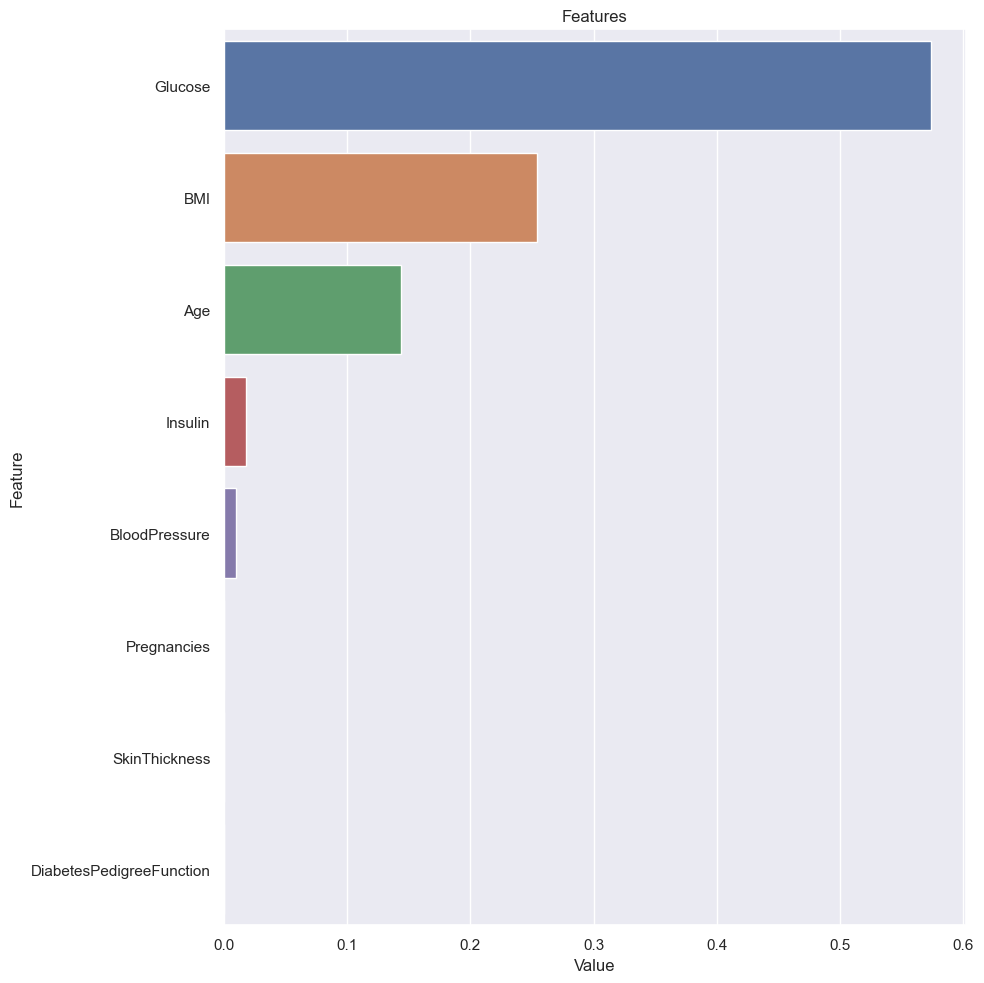

In [84]:
def plot_importance(model, features, num=len(X), save=False):
    
    #feature_importances özelliği ve features.columns'u burada tuttuk ve dataframe'e çevirdik
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    
    #daha sonra bunları sütun grafik ile görselleştirdik
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    
    #küçükten büyüğe doğru sıraladıktan sonra azalan şekilde görselleştirdik
    #num argümanı değişken sayısını veriyor
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    
    #kaydetmek istersek save argümanını true yaparız, ön tanımlı değeri false
    if save:
        plt.savefig('importances.png')


plot_importance(cart_final, X)

In [52]:
# 7. Analyzing Model Complexity with Learning Curves (BONUS)
# (öğrenme eğrileriyle model karmaşıklığını analiz etme)

In [53]:
#model karmaşıklığı arttıkça train setinin hatasının düştüğünü, test setinin hatasının da bir noktaya kadar düştükten sonra
#artmaya başladığını gözlemlemiştik
#overfit'e düştü mü sorusunun yanıtı train seti ile test setinin farklarının ayrışmaya başladığı noktadır
#bunun önüne geçmek için model karmaşıklığı azaltılabilir

In [54]:
train_score, test_score = validation_curve(cart_final, X, y,
                                           param_name="max_depth",
                                           param_range=range(1, 11),
                                           scoring="roc_auc",
                                           cv=10);

#validation_curve metodunu kullandık

In [55]:
train_score

array([[0.72320885, 0.72306132, 0.68555095, 0.72350392, 0.71698479,
        0.7011941 , 0.66131397, 0.71142923, 0.71549128, 0.71120294],
       [0.7987598 , 0.79874136, 0.76659751, 0.8000461 , 0.80217151,
        0.77901798, 0.76472568, 0.79175657, 0.80145087, 0.79440771],
       [0.84255417, 0.84810512, 0.82195943, 0.84559705, 0.8434532 ,
        0.81859843, 0.82218534, 0.83455048, 0.8413315 , 0.84593664],
       [0.8834947 , 0.88264638, 0.86355002, 0.88926233, 0.88226372,
        0.87104195, 0.86404334, 0.87285846, 0.87436639, 0.87684114],
       [0.91531581, 0.91534348, 0.90082988, 0.9263255 , 0.9175242 ,
        0.90534809, 0.88781466, 0.90936376, 0.91214417, 0.90738751],
       [0.94068234, 0.94757953, 0.9329645 , 0.94803596, 0.94784693,
        0.93404334, 0.91412633, 0.93506224, 0.94156107, 0.93325987],
       [0.968497  , 0.97154449, 0.9551314 , 0.97166436, 0.97018442,
        0.96088981, 0.94568465, 0.96332411, 0.96393939, 0.95954086],
       [0.98405256, 0.98909175, 0.9770723

In [56]:
test_score

#ikisi için de 10 tane parametrenin hata değerleri geldi

array([[0.64777778, 0.64925926, 0.68074074, 0.64481481, 0.64222222,
        0.68481481, 0.63666667, 0.75333333, 0.71692308, 0.75615385],
       [0.73407407, 0.74888889, 0.73555556, 0.71592593, 0.61703704,
        0.77777778, 0.70481481, 0.82555556, 0.74615385, 0.80038462],
       [0.78407407, 0.81333333, 0.77222222, 0.68296296, 0.69296296,
        0.82925926, 0.79259259, 0.85814815, 0.72615385, 0.80807692],
       [0.76481481, 0.81148148, 0.74962963, 0.60740741, 0.70888889,
        0.82111111, 0.83851852, 0.87333333, 0.77038462, 0.81961538],
       [0.73444444, 0.78666667, 0.77148148, 0.60037037, 0.71925926,
        0.84814815, 0.77037037, 0.88296296, 0.75730769, 0.81769231],
       [0.72814815, 0.77962963, 0.70111111, 0.59481481, 0.76259259,
        0.82740741, 0.81074074, 0.83185185, 0.76038462, 0.77692308],
       [0.74222222, 0.73185185, 0.71296296, 0.5537037 , 0.71851852,
        0.74296296, 0.81185185, 0.8462963 , 0.71076923, 0.75461538],
       [0.74481481, 0.69407407, 0.6925925

In [57]:
mean_train_score = np.mean(train_score, axis=1)
mean_train_score

array([0.70729413, 0.78976751, 0.83642714, 0.87603684, 0.90973971,
       0.93751621, 0.96304005, 0.98046698, 0.99156134, 0.99679096])

In [58]:
mean_test_score = np.mean(test_score, axis=1)
mean_test_score

array([0.68127066, 0.74061681, 0.77597863, 0.77651852, 0.76887037,
       0.7573604 , 0.7325755 , 0.71118091, 0.67825783, 0.6922037 ])

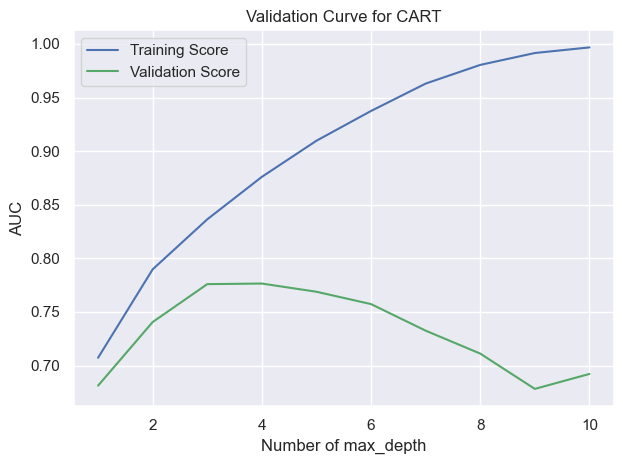

In [70]:
#train setini görselleştiriyorum
plt.plot(range(1, 11), mean_train_score,
         label="Training Score", color='b')

#validasyon (test) setini görselleştiriyorum
plt.plot(range(1, 11), mean_test_score,
         label="Validation Score", color='g')

plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [71]:
#görüyoruz ki 3ten sonra test seti, train seti ezberlemeye başladığını ve model karmaşıklığı artıkça genellenebilirlik
#yeteneğini kaybettiğini fark ediyor ve yolunu ayırıyor

#daha önce hiperparametrelerle ilgili bölümde seçtiğimiz max_depth 5 gib bir şeydi. diğeri de 4 gibi bir şeydi
#bu grafiğe göre baktığımızda max_depth 3 mü olmalı?
#model kurduğumuzda tüm değişkenleri çok değişkenli olarak değerlendiriyoruz
#yani burada fikir ediniyoruz tek başına buraya bakmıyoruz
#tutarlı gibi görünüyor çünkü çok ciddi bir fark yok

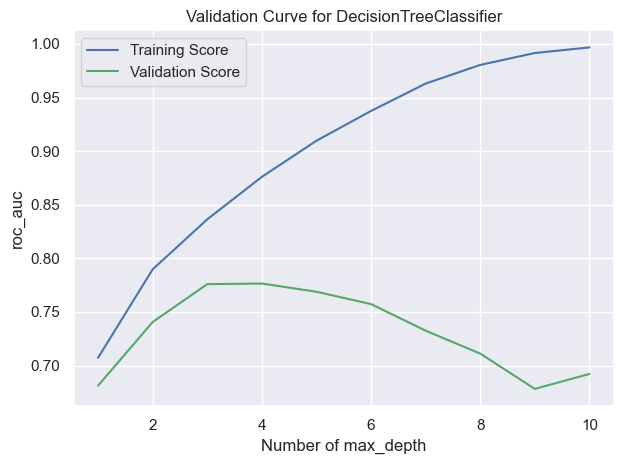

In [72]:
#buradaki işlemleri fonksiyonlaştıralım

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)
    
val_curve_params(cart_final, X, y, "max_depth", range(1, 11))

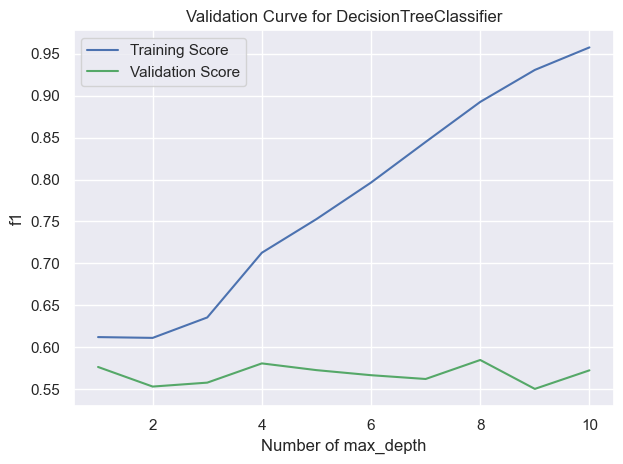

In [73]:
val_curve_params(cart_final, X, y, "max_depth", range(1, 11), scoring="f1")

In [74]:
#birden fazla hiperparametre seti olduğunda ne yaparız? 

cart_val_params = [["max_depth", range(1, 11)], ["min_samples_split", range(2, 20)]]

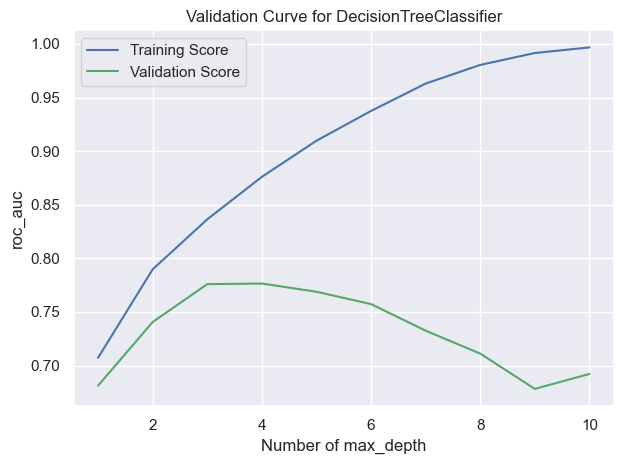

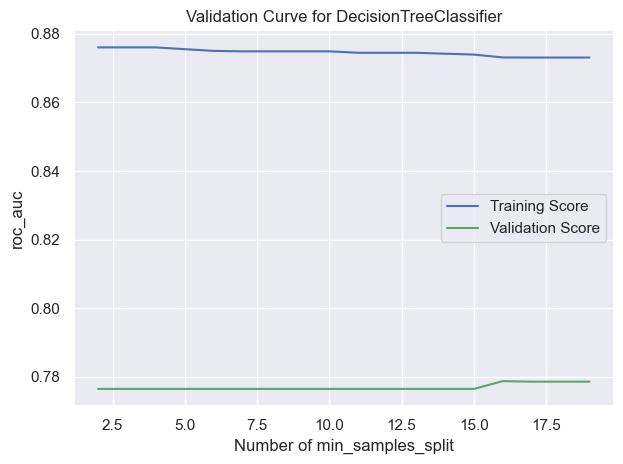

In [75]:
#şimdi bu liste içinde gezip val_curve_params fonksiyonunu uygulamamız lazım

for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

In [76]:
# 8. Visualizing the Decision Tree

In [77]:
def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)

In [78]:
tree_graph(model=cart_final, col_names=X.columns, file_name="cart_final.png")

#png dosyasını kaydetti

In [79]:
cart_final.get_params()

#max_depth : 5 , min_samples_split : 4 olmalıydı neden böyle çıktığını bulamadım bakacağım

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [82]:
# 9. Extracting Decision Rules (Karar kuralları)

In [85]:
tree_rules = export_text(cart_final, feature_names=list(X.columns))
print(tree_rules)

#export_text metodunu kullandık

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- class: 0
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- BloodPressure <= 99.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  99.00
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI >  9.65
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  99.50
|   |   |   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- Glucose <= 145.50
|   |   |   |--- Insulin <= 132.50
|   |   |   |   |--- class: 0
|   |   |   |--- Insulin >  132.50
|   |   |   |   |--- class: 0
|   |   |--- Glucose >  145.50
|   |   |   |--- Age <= 25.50
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  25

In [86]:
# 10. Extracting Python Codes of Decision Rules (Karar kurallarının python kodunu çıkartma)

In [87]:
import sklearn

In [89]:
print(skompile(cart_final.predict).to('python/code'))

#sayılar hocayla aynı çıkmadı

((((0 if x[5] <= 30.949999809265137 else 0) if x[5] <= 45.39999961853027 else
    1 if x[2] <= 99.0 else 0) if x[7] <= 28.5 else (1 if x[5] <= 
    9.649999618530273 else 0) if x[5] <= 26.350000381469727 else 0 if x[1] <=
    99.5 else 0) if x[1] <= 127.5 else ((0 if x[4] <= 132.5 else 0) if x[1] <=
    145.5 else 0 if x[7] <= 25.5 else 1) if x[5] <= 29.949999809265137 else
    (0 if x[7] <= 30.5 else 1) if x[1] <= 157.5 else 1 if x[4] <= 629.5 else 0)



In [90]:
print(skompile(cart_final.predict).to('sqlalchemy/sqlite'))

#bu hocayla aynı çıktı

SELECT CASE WHEN (x2 <= 127.5) THEN CASE WHEN (x8 <= 28.5) THEN CASE WHEN (x6 <= 45.39999961853027) THEN 0 ELSE CASE WHEN (x3 <= 99.0) THEN 1 ELSE 0 END END ELSE CASE WHEN (x6 <= 26.350000381469727) THEN CASE WHEN (x6 <= 9.649999618530273) THEN 1 ELSE 0 END ELSE 0 END END ELSE CASE WHEN (x6 <= 29.949999809265137) THEN CASE WHEN (x2 <= 145.5) THEN 0 ELSE CASE WHEN (x8 <= 25.5) THEN 0 ELSE 1 END END ELSE CASE WHEN (x2 <= 157.5) THEN CASE WHEN (x8 <= 30.5) THEN 0 ELSE 1 END ELSE CASE WHEN (x5 <= 629.5) THEN 1 ELSE 0 END END END END AS y 
FROM data


In [91]:
print(skompile(cart_final.predict).to('excel'))

A1=IF((x2<=127.5),IF((x ...223 chars skipped... ((x5<=629.5),1,0))))


In [92]:
# 11. Prediction using Python Codes

In [93]:
def predict_with_rules(x):
    return ((((((0 if x[6] <= 0.671999990940094 else 1 if x[6] <= 0.6864999830722809 else
        0) if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else ((1 if x[5
        ] <= 32.45000076293945 else 1 if x[3] <= 10.5 else 0) if x[2] <= 53.0 else
        ((0 if x[1] <= 111.5 else 0 if x[2] <= 72.0 else 1 if x[3] <= 31.0 else
        0) if x[2] <= 82.5 else 1) if x[4] <= 36.5 else 0) if x[6] <=
        0.5005000084638596 else (0 if x[1] <= 88.5 else (((0 if x[0] <= 1.0 else
        1) if x[1] <= 98.5 else 1) if x[6] <= 0.9269999861717224 else 0) if x[1
        ] <= 116.0 else 0 if x[4] <= 166.0 else 1) if x[2] <= 69.0 else ((0 if
        x[2] <= 79.0 else 0 if x[1] <= 104.5 else 1) if x[3] <= 5.5 else 0) if
        x[6] <= 1.098000019788742 else 1) if x[5] <= 45.39999961853027 else 0 if
        x[7] <= 22.5 else 1) if x[7] <= 28.5 else (1 if x[5] <=
        9.649999618530273 else 0) if x[5] <= 26.350000381469727 else (1 if x[1] <=
        28.5 else ((0 if x[0] <= 11.5 else 1 if x[5] <= 31.25 else 0) if x[1] <=
        94.5 else (1 if x[5] <= 36.19999885559082 else 0) if x[1] <= 97.5 else
        0) if x[6] <= 0.7960000038146973 else 0 if x[0] <= 3.0 else (1 if x[6] <=
        0.9614999890327454 else 0) if x[3] <= 20.0 else 1) if x[1] <= 99.5 else
        ((1 if x[5] <= 27.649999618530273 else 0 if x[0] <= 5.5 else (((1 if x[
        0] <= 7.0 else 0) if x[1] <= 103.5 else 0) if x[1] <= 118.5 else 1) if
        x[0] <= 9.0 else 0) if x[6] <= 0.19999999552965164 else ((0 if x[5] <=
        36.14999961853027 else 1) if x[1] <= 113.0 else 1) if x[0] <= 1.5 else
        (1 if x[6] <= 0.3620000034570694 else 1 if x[5] <= 30.050000190734863 else
        0) if x[2] <= 67.0 else (((0 if x[6] <= 0.2524999976158142 else 1) if x
        [1] <= 120.0 else 1 if x[6] <= 0.23899999260902405 else 1 if x[7] <=
        30.5 else 0) if x[2] <= 83.0 else 0) if x[5] <= 34.45000076293945 else
        1 if x[1] <= 101.0 else 0 if x[5] <= 43.10000038146973 else 1) if x[6] <=
        0.5609999895095825 else ((0 if x[7] <= 34.5 else 1 if x[5] <=
        33.14999961853027 else 0) if x[4] <= 120.5 else (1 if x[3] <= 47.5 else
        0) if x[4] <= 225.0 else 0) if x[0] <= 6.5 else 1) if x[1] <= 127.5 else
        (((((1 if x[1] <= 129.5 else ((1 if x[6] <= 0.5444999933242798 else 0) if
        x[2] <= 56.0 else 0) if x[2] <= 71.0 else 1) if x[2] <= 73.0 else 0) if
        x[5] <= 28.149999618530273 else (1 if x[1] <= 135.0 else 0) if x[3] <=
        21.0 else 1) if x[4] <= 132.5 else 0) if x[1] <= 145.5 else 0 if x[7] <=
        25.5 else ((0 if x[1] <= 151.0 else 1) if x[5] <= 27.09999942779541 else
        ((1 if x[0] <= 6.5 else 0) if x[6] <= 0.3974999934434891 else 0) if x[2
        ] <= 82.0 else 0) if x[7] <= 61.0 else 0) if x[5] <= 29.949999809265137
         else ((1 if x[2] <= 61.0 else (((((0 if x[6] <= 0.18299999833106995 else
        1) if x[0] <= 0.5 else 1 if x[5] <= 32.45000076293945 else 0) if x[2] <=
        73.0 else 0) if x[0] <= 4.5 else 1 if x[6] <= 0.6169999837875366 else 0
        ) if x[6] <= 1.1414999961853027 else 1) if x[5] <= 41.79999923706055 else
        1 if x[6] <= 0.37299999594688416 else 1 if x[1] <= 142.5 else 0) if x[7
        ] <= 30.5 else (((1 if x[6] <= 0.13649999350309372 else 0 if x[5] <=
        32.45000076293945 else 1 if x[5] <= 33.05000114440918 else (0 if x[6] <=
        0.25599999725818634 else (0 if x[1] <= 130.5 else 1) if x[0] <= 8.5 else
        0) if x[0] <= 13.5 else 1) if x[2] <= 92.0 else 1) if x[5] <=
        45.54999923706055 else 1) if x[6] <= 0.4294999986886978 else (1 if x[5] <=
        40.05000114440918 else 0 if x[5] <= 40.89999961853027 else 1) if x[4] <=
        333.5 else 1 if x[2] <= 64.0 else 0) if x[1] <= 157.5 else ((((1 if x[7
        ] <= 25.5 else 0 if x[4] <= 87.5 else 1 if x[5] <= 45.60000038146973 else
        0) if x[7] <= 37.5 else 1 if x[7] <= 56.5 else 0 if x[6] <=
        0.22100000083446503 else 1) if x[6] <= 0.28849999606609344 else 0) if x
        [6] <= 0.3004999905824661 else 1 if x[7] <= 44.0 else (0 if x[7] <=
        51.0 else 1 if x[6] <= 1.1565000414848328 else 0) if x[0] <= 6.5 else 1
        ) if x[4] <= 629.5 else 1 if x[6] <= 0.4124999940395355 else 0)

In [94]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [95]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

In [96]:
predict_with_rules(x)

#diyabet değildir çıktı

0

In [97]:
x = [6, 148, 70, 35, 0, 30, 0.62, 50]

In [98]:
predict_with_rules(x)

#diyabettir çıktı

1

In [99]:
# 12. Saving and Loading Model

In [100]:
joblib.dump(cart_final, "cart_final.pkl")

#bir pkl dosyası geldi

['cart_final.pkl']

In [101]:
cart_model_from_disc = joblib.load("cart_final.pkl")

#pkl dosyasını yükledik yani kurduğumuz modeli yükledik

In [102]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

#yeni bir gözlem birimi

In [104]:
cart_model_from_disc.predict(pd.DataFrame(x).T)

#x'i dataframe'e çevirmemiz gerekiyordu 
#tahmin sonucu 1 geldi yani diyabet

array([1], dtype=int64)